### Setup

In [1]:
# Import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, RichProgressBar
from pytorch_lightning.callbacks.progress.rich_progress import RichProgressBarTheme

from torchvision import transforms

from dataset import CellDataset
from model.counting_model import CSRNet
from model.twobranch import countXplain

import matplotlib.pyplot as plt
import numpy as np
import cv2
import random
from glob import glob
import seaborn as sns
import pandas as pd
from sklearn.decomposition import PCA

from helpers import *

In [2]:
# Initialize the model
proto_model = initialize_model(r"Saved Models/DCC/64_depth/DCC_best_no_bg.ckpt", 'DCC_CSRNet.ckpt' )
proto_model.eval()

print("Model initialized")


Model initialized


/Users/abdu/miniconda3/envs/torchenv/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'count_model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['count_model'])`.
  rank_zero_warn(


In [ ]:
# Load the explanandum model
csr = CSRNet(learning_rate=1e-5).load_from_checkpoint(r'DCC_CSRNet.ckpt')
csr.eval()

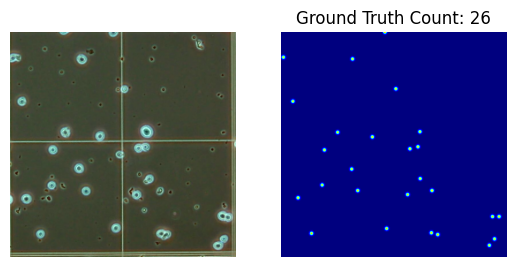

In [3]:
# Get a random image and its density map
img,dmap = get_random_image('DCC')

plt.subplot(1,2,1)
plt.imshow(img)
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(dmap,cmap='jet')
plt.axis('off')
plt.title('Ground Truth Count: {}'.format(int(np.sum(dmap))))
plt.show()

image = apply_transforms(img)
image = image.unsqueeze(0)

In [4]:
# Perform a forward pass with the image
fmaps,bg, fg, distances = proto_model(image)

similarities = proto_model.distance2similarity(distances)

print(f"Predicted count: {int(torch.sum(fg))}")

Predicted count: 32


### Visual Analysis

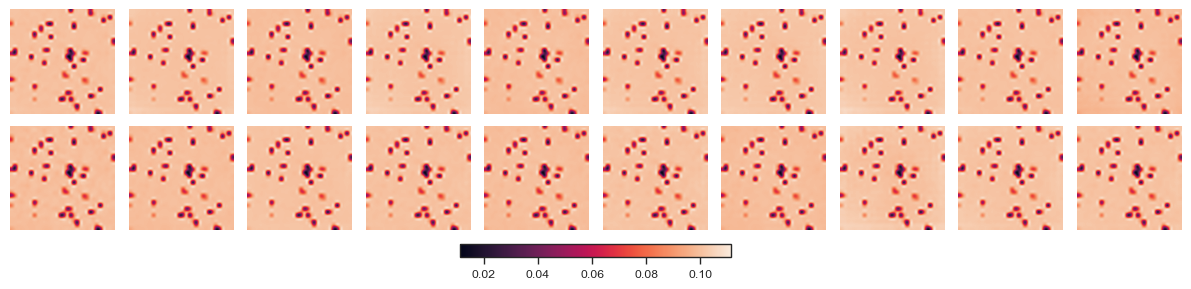

In [121]:
similarity_map(proto_model,similarities)

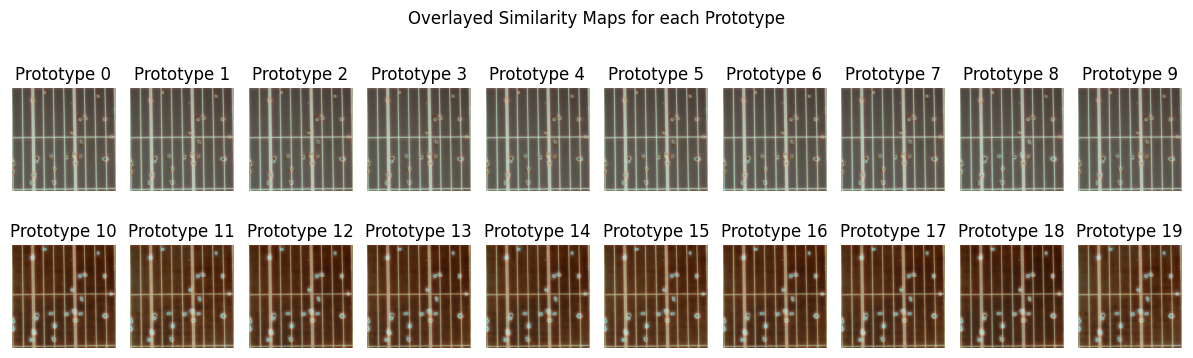

In [6]:
overlay_similarity(proto_model,img,similarities)

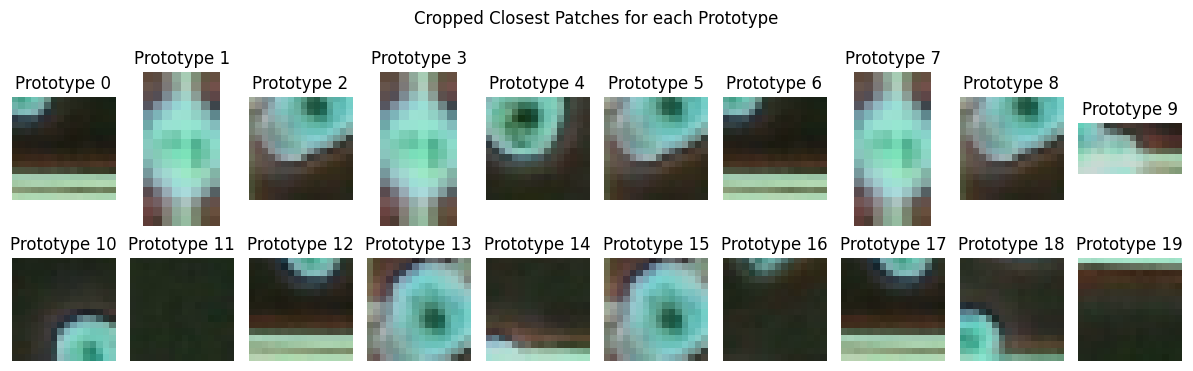

In [36]:
crop_closest(proto_model,similarities,img)

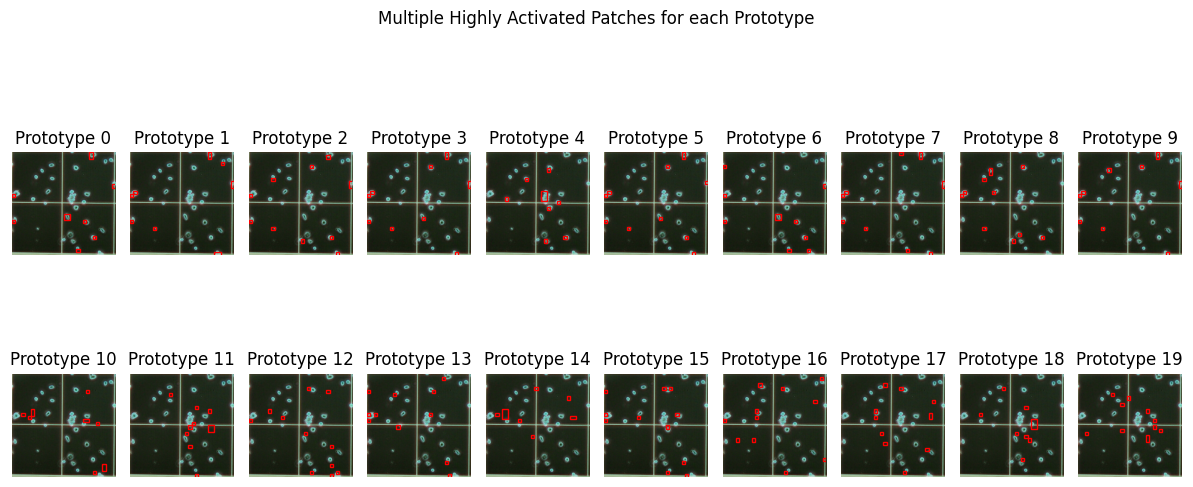

In [37]:
multiple_highly_activated(proto_model,similarities,img, percentile=99)

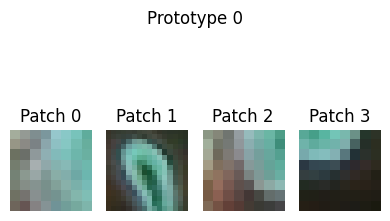

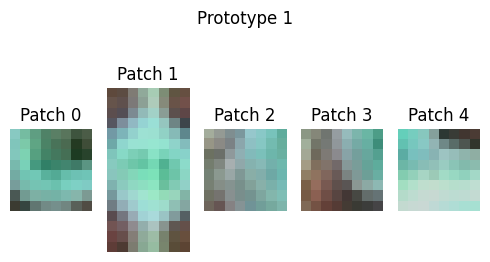

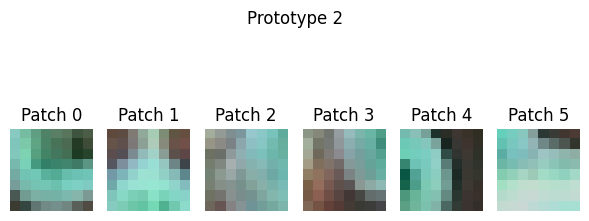

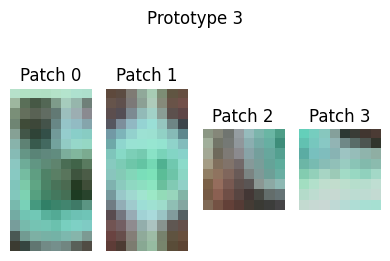

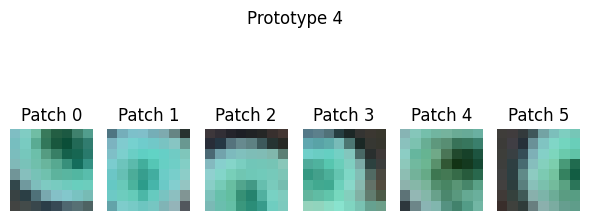

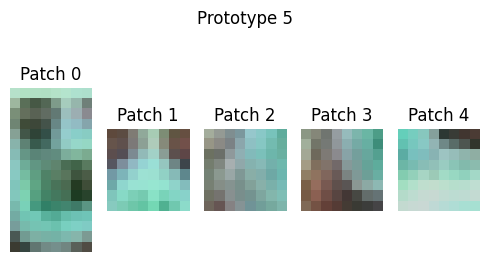

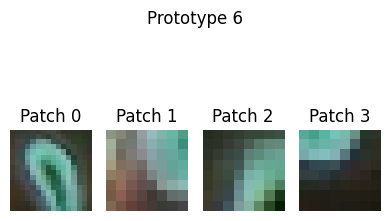

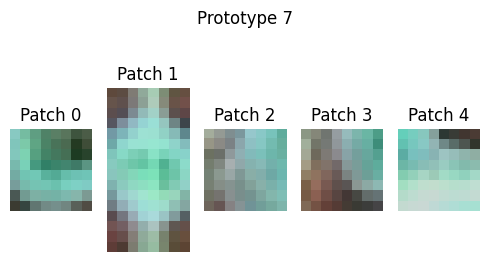

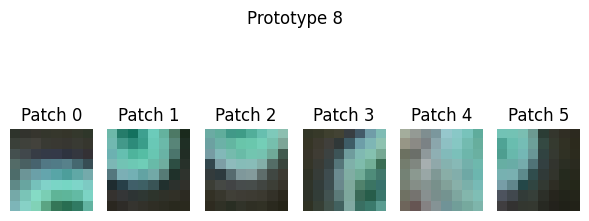

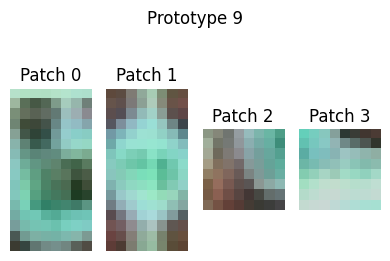

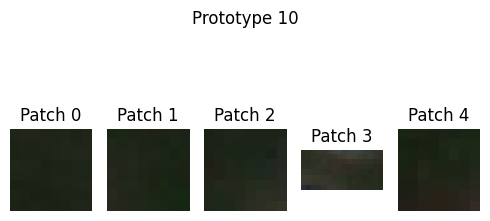

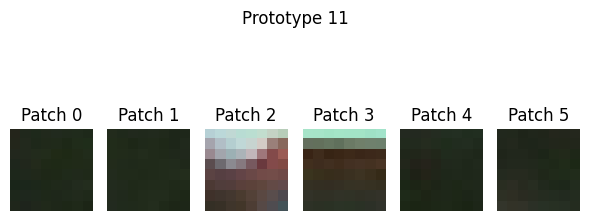

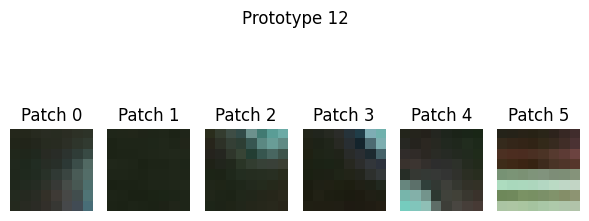

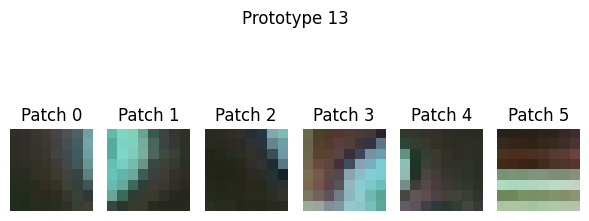

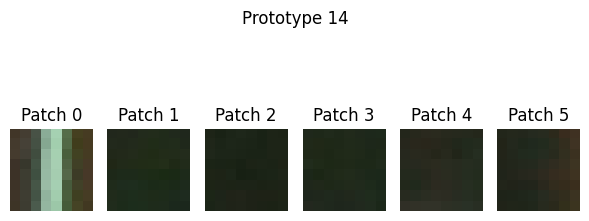

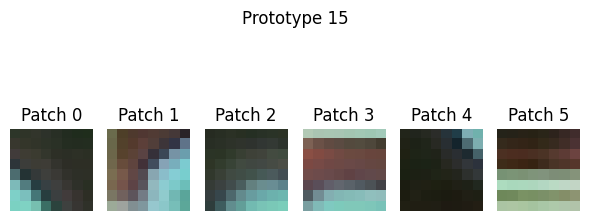

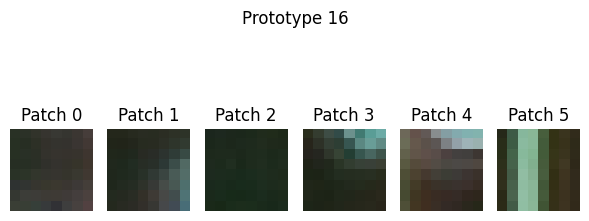

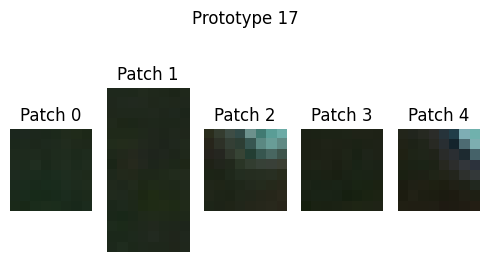

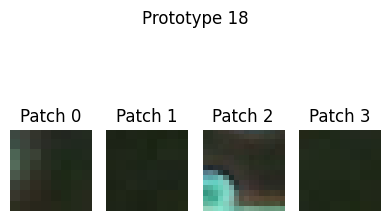

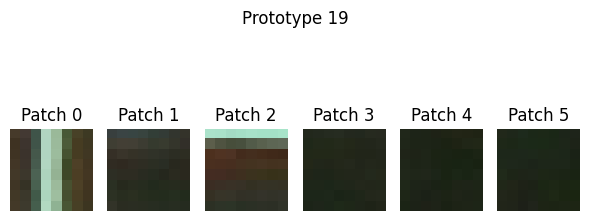

In [38]:
crop_multiple_highly_activated(proto_model,similarities,img, percentile=99.5)

### Quantitative Analysis

In [6]:
# Prototype faithfullness (OLD)
all_imgs = glob(r'../Datasets/DCC/trainval/images/*.png')

faithfullness = proto_faithfulness(all_imgs,proto_model,csr)

print(f"Faithfullness: {faithfullness}")

Faithfullness: defaultdict(<class 'int'>, {0: 83, 2: 79, 3: 96})


In [9]:
# Wilcoxon signed rank test with bounding box
all_imgs = glob(r'../Datasets/DCC/trainval/images/*.png')

p_values = wilcoxon_signed_rank_test(all_imgs,proto_model,csr)

print(f"p-values: {p_values}")

# print the indices of prototypes with p-value < 0.05
significant = [i for i in range(len(p_values)) if p_values[i] < 0.05]
print(f"Significant prototypes: {significant}")


Calculating the Wilcoxon signed rank test for 20 prototypes


100%|██████████| 100/100 [05:13<00:00,  3.14s/it]

p-value: [2.0696869543572095e-18, 2.265930530554773e-18, 2.634602240773196e-18, 2.1985567770909467e-18, 2.0696869543572095e-18, 2.265930530554773e-18, 1.9482799225479546e-18, 3.6669034896259105e-18, 1.9482799225479546e-18, 1.9482799225479546e-18, 1.0, 0.9999999999999996, 0.9999999999999999, 1.0, 0.9999999999999931, 0.9999999999970806, 0.9999999999995144, 1.0, 0.9999999999999997, 0.9999999999999847]


In [142]:
erased = erase_closest_patch(proto_model,similarities,img)

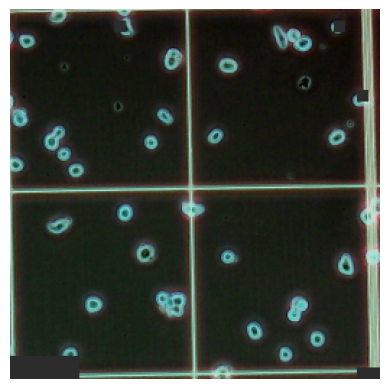

In [143]:
plt.imshow(erased[0])
plt.axis('off')
plt.show()


In [228]:
# for each image in the test set, get the predicted count and the ground truth count
preds = []
gts = []
csr_preds = []

test_loader = proto_model.test_dataloader()


for img, dmap in test_loader:
    # Perform a forward pass with the image
    fmaps,bg, fg, distances = proto_model(img)
    pred = int(torch.sum(fg))
    pred_csr = int(torch.sum(csr(img)))
    gt = int(torch.sum(dmap))
    preds.append(pred)
    gts.append(gt)
    csr_preds.append(pred_csr)

print(len(preds))
print(len(gts))
print(len(csr_preds))

# Calculate the mean absolute error between the predicted counts and the ground truth counts
proto_mae = np.mean(np.abs(np.array(preds) - np.array(gts)))
print(f"Proto MAE: {proto_mae}")

csr_mae = np.mean(np.abs(np.array(csr_preds) - np.array(gts)))
print(f"CSRNet MAE: {csr_mae}")






76
76
76
Proto MAE: 4.434210526315789
CSRNet MAE: 3.9473684210526314


In [5]:
# Wilcoxon signed rank test with masking pixels
all_imgs = glob(r'../Datasets/DCC/trainval/images/*.png')


p_values = statistical_test(all_imgs, proto_model, csr)

print(f"p-values: {p_values}")
for i in range(len(p_values)):
    if p_values[i] < 0.05:
        print(f"Prototype {i} is significant with p-value {p_values[i]}")

Calculating the Wilcoxon signed rank test for 20 prototypes


100%|██████████| 100/100 [07:43<00:00,  4.63s/it]


### Latent Space Analysis

In [63]:
# Get the prototypes
prototypes = proto_model.prototypes.detach().cpu().numpy()
# reshape each prototype to d*h*w
prototypes = prototypes.reshape(
(-1, prototypes.shape[1]* prototypes.shape[2]* prototypes.shape[3])
)

num_prototypes = proto_model.prototypes.shape[0]

print(prototypes.shape) # Will be (20,32)

(20, 64)


In [52]:
# Show PCA visualization of prototypes
pca = PCA(n_components=2)
pca_proto = pca.fit_transform(prototypes)

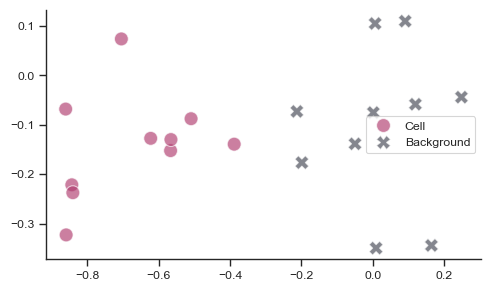

In [64]:
pca_proto = pca.transform(prototypes)
pca_df = pd.DataFrame(pca_proto, columns=['pc1', 'pc2'])

pca_df['label'] = ['Cell'] * int(len(pca_df) / 2) + ['Background'] * int(len(pca_df) / 2)

plt.figure(figsize=(5,3))
sns.set_style('ticks')
sns.set_context('paper')




sns.scatterplot(data=pca_df, x='pc1', y='pc2', hue='label', style=pca_df['label'],alpha = .65, s=100, palette=['#AF3B6E', '#424651'], markers=['o','X'])

sns.despine()
plt.legend(loc='best')

# remove axis titles
plt.xlabel('')
plt.ylabel('')
plt.tight_layout()
# plt.savefig('Figures/PCA_vis_no_div.png', dpi=400)


# plt.title('PCA visualization of prototypes')
plt.show()

### Proto-feature ablation

In [54]:
train_loader = proto_model.train_dataloader()

max_features = []

# Get the first batch
img, dmap = next(iter(train_loader))

print(img.shape)
print(dmap.shape)


for img, dmap in train_loader:
    # Perform a forward pass with the image
    fmaps,bg, fg, distances = proto_model(img)

    # get the average feature map
    avg_fmaps = torch.mean(fmaps, dim=1, keepdim=True).squeeze(0).squeeze(0)

    # find the max value in the feature map
    max_idx = torch.argmax(avg_fmaps)

    idx_2d = (max_idx // avg_fmaps.shape[1], max_idx % avg_fmaps.shape[1])

    # get the feature vector at the max index from the original fmaps
    max_fmap = fmaps[0, :, idx_2d[0], idx_2d[1]]

    # append the feature vector to the list
    max_features.append(max_fmap.detach().cpu().numpy())

max_features = np.array(max_features)
print(max_features.shape)
    


torch.Size([1, 3, 256, 256])
torch.Size([1, 1, 32, 32])
(100, 64)


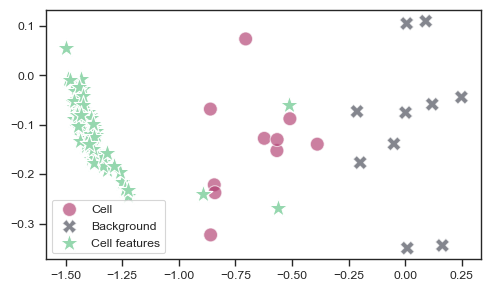

In [65]:
transformed_fmaps = pca.transform(max_features)



plt.figure(figsize=(5,3))
sns.scatterplot(data=pca_df, x='pc1', y='pc2', hue='label', style=pca_df['label'],alpha = .65, s=100, palette=['#AF3B6E', '#424651'], markers=['o','X'])
plt.scatter(transformed_fmaps[:,0], transformed_fmaps[:,1], s=200, marker='*', c='#95D7AE', label = "Cell features", edgecolor='white')
plt.xlabel('')
plt.ylabel('')
plt.legend(loc='best')

plt.tight_layout()
plt.savefig('Figures/PCA_vis_no_proto', dpi=400)
plt.show()
